<center>
<h1> Credit Risk Analytics
</center>


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 720x540 with 0 Axes>

In [3]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [4]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [5]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [7]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print (numeric_var_names)
print (cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [8]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [9]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

""
0
1
2
3
4


In [10]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [11]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [12]:
#Detailed profiling using pandas profiling

pandas_profiling.ProfileReport(bankloans)

Number of variables,9
Number of observations,850
Total Missing (%),2.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [13]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull()==0]
bankloans_new = bankloans_num[bankloans_num.default.isnull()==1]
pandas_profiling.ProfileReport(bankloans_existing)

Number of variables,9
Number of observations,700
Total Missing (%),0.0%
Total size in memory,54.7 KiB
Average record size in memory,80.0 B
Numeric,8
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [15]:
pandas_profiling.ProfileReport(bankloans_existing)

Number of variables,9
Number of observations,700
Total Missing (%),0.0%
Total size in memory,54.7 KiB
Average record size in memory,80.0 B
Numeric,8
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [16]:
#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

C:\Users\gaura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gaura\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


In [17]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [18]:
bankloans_existing.corr()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016576,0.537417,0.596973,0.521450,0.016926,0.308318,0.348911,-0.138654
ed,0.016576,1.000000,-0.158071,0.055560,0.225395,0.009992,0.103012,0.156523,0.118521
employ,0.537417,-0.158071,1.000000,0.324859,0.665369,-0.035332,0.405959,0.419337,-0.287197
address,0.596973,0.055560,0.324859,1.000000,0.345067,0.014967,0.215397,0.234896,-0.165389
income,0.521450,0.225395,0.665369,0.345067,1.000000,-0.022541,0.553114,0.626787,-0.099553
debtinc,0.016926,0.009992,-0.035332,0.014967,-0.022541,1.000000,0.534602,0.603630,0.388556
creddebt,0.308318,0.103012,0.405959,0.215397,0.553114,0.534602,1.000000,0.639984,0.238179
othdebt,0.348911,0.156523,0.419337,0.234896,0.626787,0.603630,0.639984,1.000000,0.138962
default,-0.138654,0.118521,-0.287197,-0.165389,-0.099553,0.388556,0.238179,0.138962,1.000000


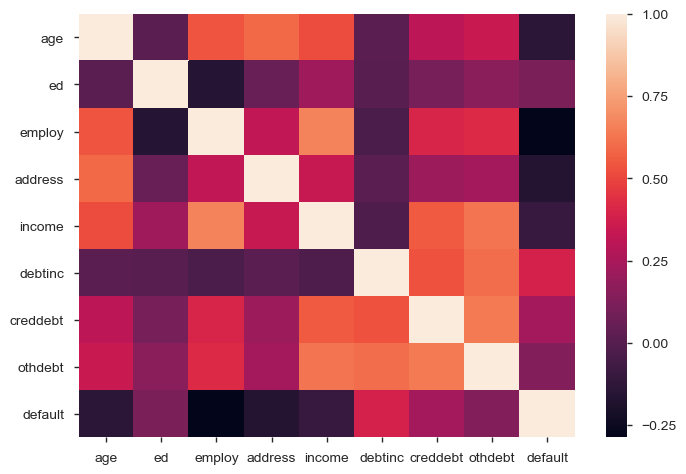

In [19]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_existing.corr())

###### 2.1 Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)

In [21]:
## Numerical Variable
tstats_df = pd.DataFrame()
for num_variable in numeric_var_names:
    tstats = stats.ttest_ind(bankloans_existing[bankloans_existing['default']==1][num_variable],bankloans_existing[bankloans_existing['default']==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

print(tstats_df)

  Variable Name T-Statistic      P-Value
0           age    -3.69893  0.000233527
1            ed     3.15351   0.00168236
2        employ    -7.92136  9.27995e-15
3       address    -4.43055  1.09104e-05
4        income    -2.64329   0.00839468
5       debtinc     11.1409  1.20241e-26
6      creddebt     6.47909   1.7428e-10
7       othdebt      3.7073  0.000226095
8       default         inf            0


###### 2.2 Data Exploratory Analysis
    - Visualization of variable importance

C:\Users\gaura\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\gaura\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


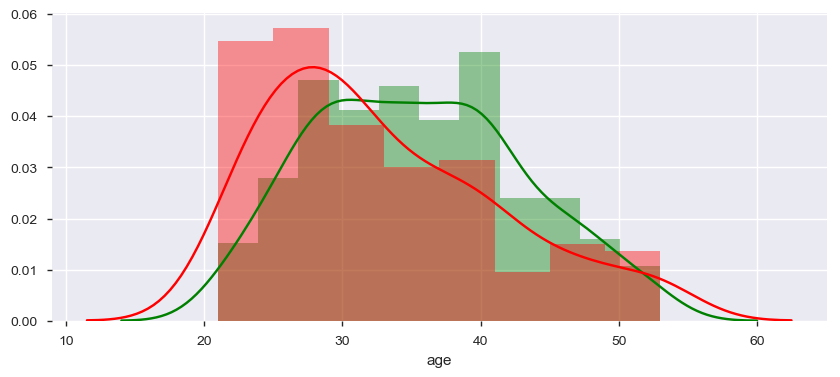

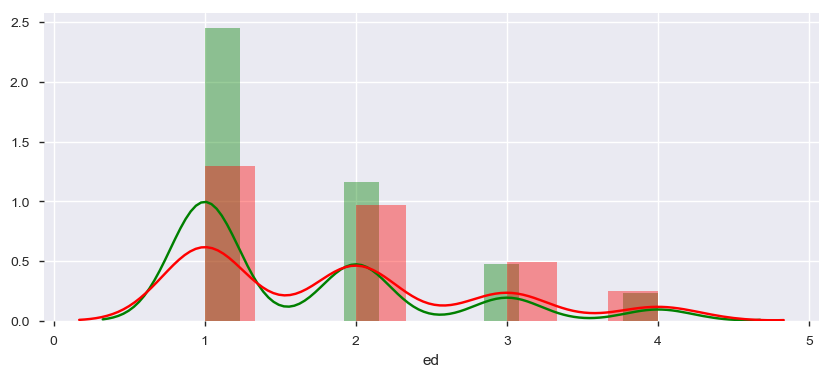

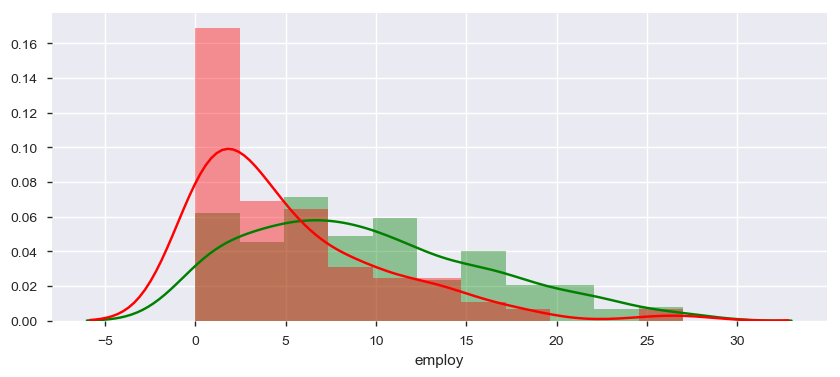

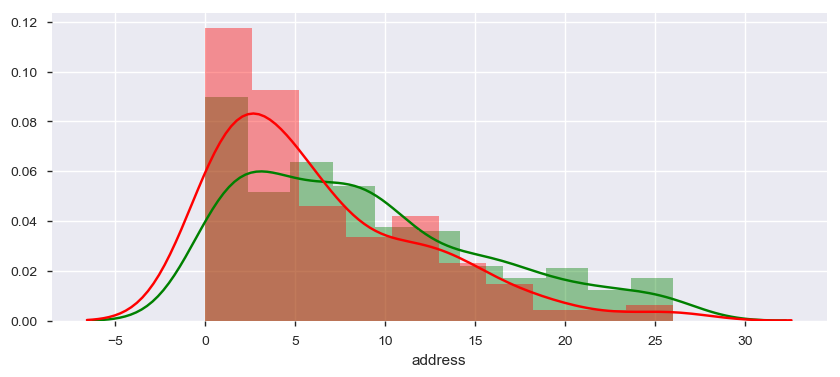

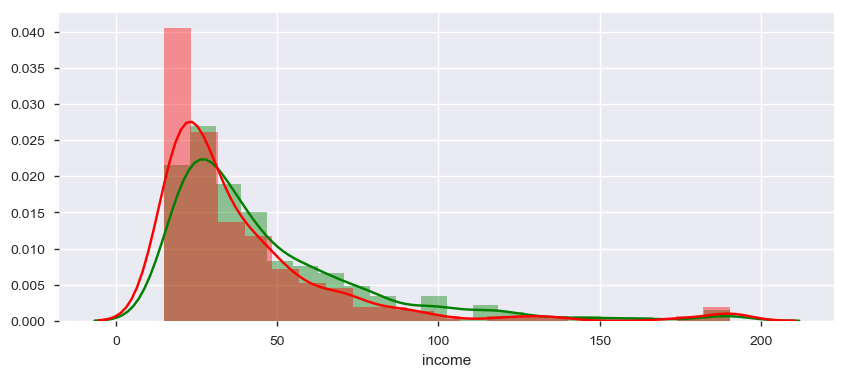

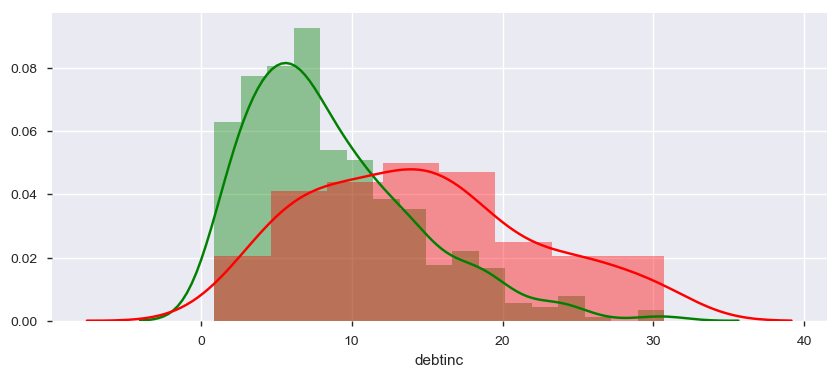

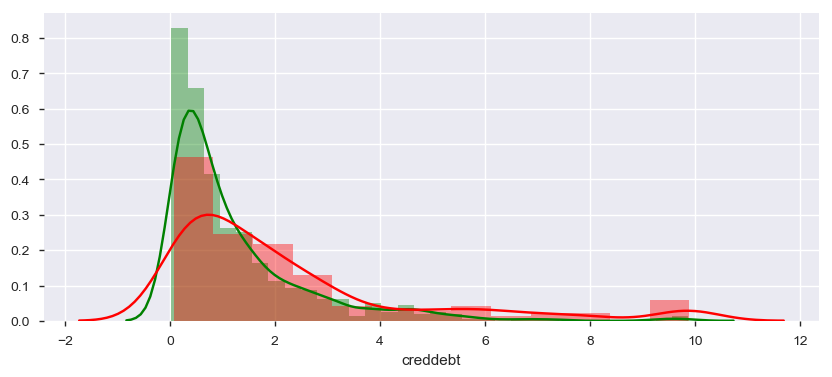

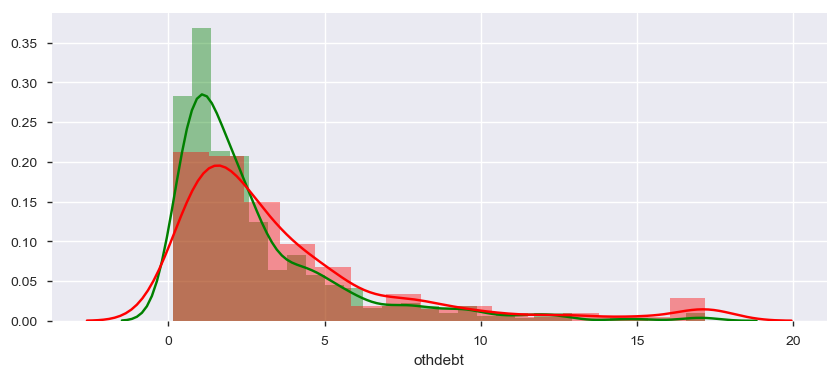

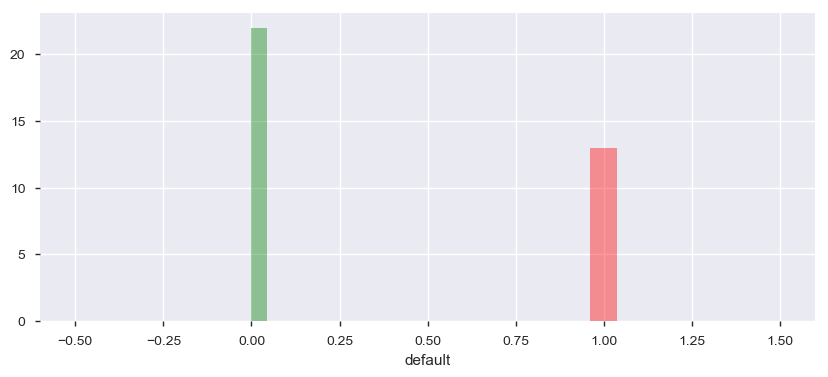

In [26]:
import matplotlib.pyplot as plt
bp = PdfPages('Density Plots with Attrition Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    #sns.distplot(hrdf[num_variable], kde=False, color='g', hist=True)
    sns.distplot(bankloans_existing[bankloans_existing['default']==0][num_variable], label='Not Default', color='g', hist=True, norm_hist=False)
    sns.distplot(bankloans_existing[bankloans_existing['default']==1][num_variable], label='Default', color='r', hist=True, norm_hist=False)
    bp.savefig(fig)

bp.close()

######  Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [30]:
somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    summ = result.summary()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Variable Name,SomersD
0,address,0.222384
0,age,0.206329
0,creddebt,0.272378
0,debtinc,0.470506
0,ed,0.148302
0,employ,0.409138
0,income,0.200273
0,othdebt,0.173806


In [32]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

a,b = dmatrices(formula_like='default ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

vif

,VIF Factor,features
0,36.910987,Intercept
1,1.561802,address
2,2.037593,age
3,2.628899,creddebt
4,3.910509,debtinc
5,1.287345,ed
6,2.401544,employ
7,5.121585,income
8,4.562072,othdebt


In [33]:
#Train and Test split

train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')

In [34]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                            8
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.2749
Time:                        19:23:20   Log-Likelihood:                -208.44
converged:                       True   LL-Null:                       -287.47
                                        LLR p-value:                 4.065e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3844      0.736     -1.881      0.060      -2.827       0.058
address       -0.0853      0.026     -3.306      0.001      -0.136      -0.035
age            0.0389      0.020      1.924      0.054      -0.001       0.078
creddebt       0.6410      0.139      4.628      0.000       0.370       0.912
debtinc        0.0353      0.039      0.907      0.365      -0.041       0.112
ed             0.0080      0.142      0.056      0.955      -0.271       0.287
employ        -0.2650      0.040     -6.641      0.000      -0.343      -0.187
income        -0.0089      0.012     -0.721      0.471      -0.033       0.015
othdebt        0.1249      0.102      1.226      0.220      -0.075       0.325
==============================================================================
"""

In [35]:
# 2*AUC-1 give goodness of model 
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.6816619151433843
The Gini Index for the model built on the Test Data is :  0.7665103308404106


In [38]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X)) # our prediction in probability
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.573708
649,0.0,0.500030
291,0.0,0.060040
420,1.0,0.574824
177,0.0,0.132731


In [39]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.198828
500,0.0,0.485425
396,0.0,0.051498
155,0.0,0.279162
321,1.0,0.334386


In [40]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [41]:
roc_like_df

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,0.992537,0.193820
0,0.040816,0.985075,0.286517
0,0.061224,0.970149,0.351124
0,0.081633,0.962687,0.401685
0,0.102041,0.955224,0.446629
0,0.122449,0.925373,0.488764
0,0.142857,0.925373,0.522472
0,0.163265,0.917910,0.556180
0,0.183673,0.895522,0.595506


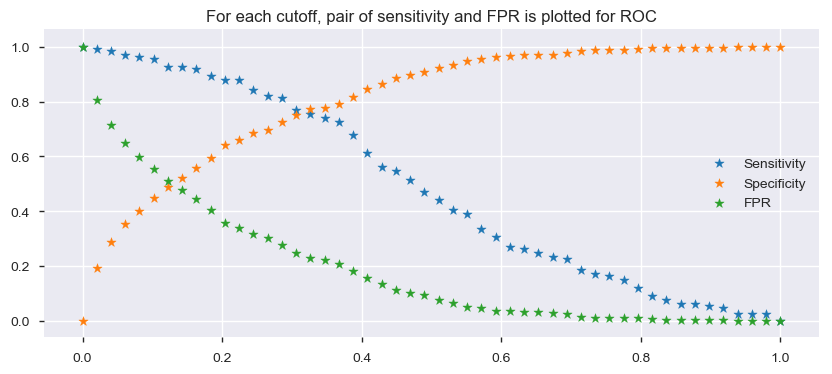

In [42]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [43]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.22449,0.880597,0.660112,1.540709


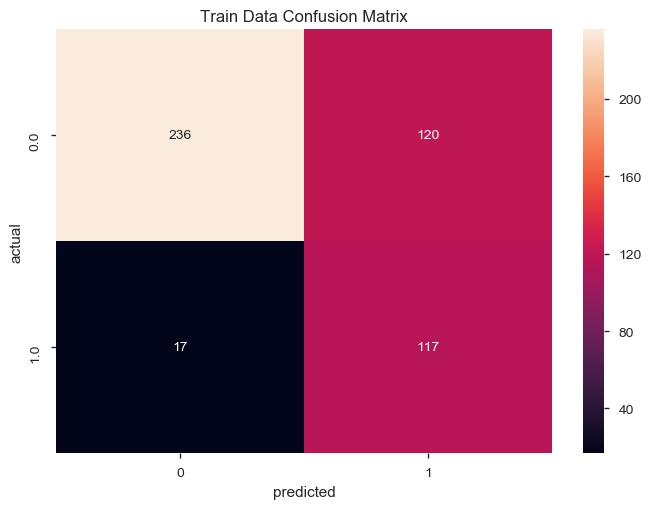

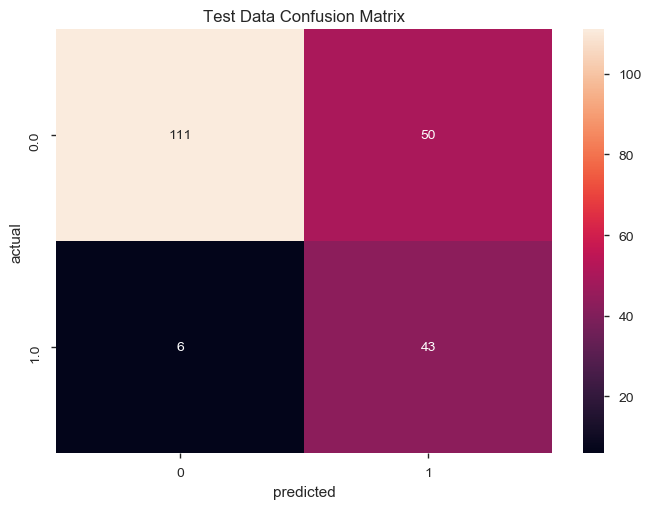

In [45]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()
# (117+236)/(117+236+120+17)

In [46]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.7333333333333333
